<a href="https://colab.research.google.com/github/Simoni2412/Hyperpigmentation_detection/blob/main/Hyperpigmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install ultralytics roboflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.9 MB/s eta 0:00:00


In [2]:
# YOLOv8 Segmentation for Hyperpigmentation Detection
# Complete Google Colab Notebook

# ============================================================================
# STEP 1: Setup and Installation
# ============================================================================

# Import libraries
from ultralytics import YOLO
from roboflow import Roboflow
import os
from IPython.display import Image, display
import matplotlib.pyplot as plt
import cv2
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# ============================================================================
# STEP 2: Mount Google Drive and Load Your Dataset
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

# TODO: Update this path to where YOU uploaded your dataset in Google Drive
# Example: '/content/drive/MyDrive/YourFolderName/hyperpigmentation_data'
DRIVE_DATASET_PATH = '/content/drive/MyDrive/hyperpigmentation_dataset.v2i.yolov8'

# Local path in Colab for faster training
COLAB_DATASET_PATH = '/content/dataset'

# Check if dataset exists in Drive
if not os.path.exists(DRIVE_DATASET_PATH):
    print(f"❌ ERROR: Dataset not found at: {DRIVE_DATASET_PATH}")
    print("\nPlease update DRIVE_DATASET_PATH (line 30) to match your actual folder location.")
    print("\nTo find your path:")
    print("1. Go to Files tab (left sidebar)")
    print("2. Navigate to drive → MyDrive → your_folder")
    print("3. Right-click on folder → Copy path")
    raise FileNotFoundError(f"Dataset not found at {DRIVE_DATASET_PATH}")

print("✓ Dataset found in Google Drive!")
print(f"Copying from Drive to Colab workspace for faster training...")

# Copy from Drive to Colab local storage (much faster for training)
import shutil
if os.path.exists(COLAB_DATASET_PATH):
    shutil.rmtree(COLAB_DATASET_PATH)
shutil.copytree(DRIVE_DATASET_PATH, COLAB_DATASET_PATH)

dataset_location = COLAB_DATASET_PATH
print(f"✓ Dataset ready at: {dataset_location}")
print(f"Copy completed! Training will now be much faster.\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
❌ ERROR: Dataset not found at: /content/drive/MyDrive/hyperpigmentation_dataset.v2i.yolov8

Please update DRIVE_DATASET_PATH (line 30) to match your actual folder location.

To find your path:
1. Go to Files tab (left sidebar)
2. Navigate to drive → MyDrive → your_folder
3. Right-click on folder → Copy path


FileNotFoundError: Dataset not found at /content/drive/MyDrive/hyperpigmentation_dataset.v2i.yolov8

In [ ]:
# ============================================================================
# STEP 3: Verify Data Structure
# ============================================================================

# Check data.yaml file
data_yaml_path = f"{dataset_location}/data.yaml"
print("\n=== Data Configuration ===")
with open(data_yaml_path, 'r') as f:
    print(f.read())

# Check number of images
train_images = os.listdir(f"{dataset_location}/train/images")
val_images = os.listdir(f"{dataset_location}/valid/images")
test_images = os.listdir(f"{dataset_location}/test/images") if os.path.exists(f"{dataset_location}/test/images") else []

print(f"\n=== Dataset Statistics ===")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

In [ ]:
# ============================================================================
# STEP 4: Visualize Sample Data
# ============================================================================

def visualize_yolo_annotation(image_path, label_path):
    """Visualize image with YOLO segmentation annotations"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Read YOLO annotation
    with open(label_path, 'r') as f:
        annotations = f.readlines()

    # Draw each annotation
    for ann in annotations:
        data = ann.strip().split()
        class_id = int(data[0])

        # Convert normalized coordinates to pixel coordinates
        points = []
        for i in range(1, len(data), 2):
            x = float(data[i]) * w
            y = float(data[i+1]) * h
            points.append([int(x), int(y)])

        points = np.array(points, dtype=np.int32)

        # Draw polygon
        cv2.polylines(img, [points], True, (255, 0, 0), 2)
        cv2.fillPoly(img, [points], (255, 0, 0, 50))

    return img

# Visualize first 3 training samples
print("\n=== Sample Training Images ===")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx in range(min(3, len(train_images))):
    img_name = train_images[idx]
    img_path = f"{dataset_location}/train/images/{img_name}"
    label_path = f"{dataset_location}/train/labels/{img_name.replace('.jpg', '.txt').replace('.png', '.txt')}"

    if os.path.exists(label_path):
        img = visualize_yolo_annotation(img_path, label_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"Sample {idx+1}")

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 5: Train YOLOv8 Segmentation Model
# ============================================================================

print("\n=== Starting Training ===")

# Initialize model with pretrained weights
# Options: yolov8n-seg.pt (nano), yolov8s-seg.pt (small), yolov8m-seg.pt (medium)
# yolov8l-seg.pt (large), yolov8x-seg.pt (extra large)
model = YOLO('yolov8m-seg.pt')  # Medium model - good balance

# Training configuration
results = model.train(
    data=data_yaml_path,
    epochs=100,                    # Number of epochs
    imgsz=640,                     # Image size
    batch=16,                      # Batch size (reduce if GPU memory issues)
    patience=20,                   # Early stopping patience
    save=True,                     # Save checkpoints
    device=0,                      # 0 for GPU, 'cpu' for CPU
    project='hyperpigmentation',   # Project name
    name='yolov8m_seg',           # Experiment name
    exist_ok=True,                # Overwrite existing

    # Augmentation
    hsv_h=0.015,                  # HSV-Hue augmentation
    hsv_s=0.7,                    # HSV-Saturation augmentation
    hsv_v=0.4,                    # HSV-Value augmentation
    degrees=10,                   # Rotation
    translate=0.1,                # Translation
    scale=0.5,                    # Scale
    flipud=0.0,                   # Vertical flip (0 for medical images)
    fliplr=0.5,                   # Horizontal flip
    mosaic=1.0,                   # Mosaic augmentation

    # Optimization
    optimizer='AdamW',            # Optimizer
    lr0=0.01,                     # Initial learning rate
    lrf=0.01,                     # Final learning rate factor
    momentum=0.937,               # Momentum
    weight_decay=0.0005,          # Weight decay
    warmup_epochs=3,              # Warmup epochs

    # Loss weights
    box=7.5,                      # Box loss weight
    cls=0.5,                      # Classification loss weight
    dfl=1.5,                      # Distribution focal loss weight
)

print("\n=== Training Complete! ===")

# ============================================================================
# STEP 6: Evaluate Model
# ============================================================================

print("\n=== Evaluating Model ===")

# Load best model
best_model = YOLO('hyperpigmentation/yolov8m_seg/weights/best.pt')

# Validate on validation set
metrics = best_model.val()

# Print metrics
print(f"\n=== Validation Metrics ===")
print(f"mAP50 (Box): {metrics.box.map50:.4f}")
print(f"mAP50-95 (Box): {metrics.box.map:.4f}")
print(f"mAP50 (Mask): {metrics.seg.map50:.4f}")
print(f"mAP50-95 (Mask): {metrics.seg.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

# Display training curves
display(Image('hyperpigmentation/yolov8m_seg/results.png'))

# ============================================================================
# STEP 7: Test Inference
# ============================================================================

print("\n=== Running Inference on Test Images ===")

# Run inference on test/validation images
test_dir = f"{dataset_location}/test/images" if os.path.exists(f"{dataset_location}/test/images") else f"{dataset_location}/valid/images"
test_images_list = os.listdir(test_dir)[:5]  # First 5 images

results_inference = best_model.predict(
    source=test_dir,
    save=True,
    conf=0.25,                    # Confidence threshold
    iou=0.7,                      # NMS IoU threshold
    project='hyperpigmentation',
    name='predictions',
    exist_ok=True
)

print(f"Predictions saved to: hyperpigmentation/predictions/")

# Display predictions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, img_name in enumerate(test_images_list[:6]):
    img_path = f"{test_dir}/{img_name}"

    # Run prediction
    result = best_model(img_path)[0]

    # Plot result
    img_with_pred = result.plot()
    img_with_pred = cv2.cvtColor(img_with_pred, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(img_with_pred)
    axes[idx].axis('off')
    axes[idx].set_title(f"Prediction {idx+1}")

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 8: Inference on Single Image
# ============================================================================

def predict_hyperpigmentation(image_path, conf_threshold=0.25):
    """
    Predict hyperpigmentation on a single image

    Args:
        image_path: Path to image
        conf_threshold: Confidence threshold for detection

    Returns:
        results: YOLO results object
    """
    results = best_model(image_path, conf=conf_threshold)

    # Get detection info
    if len(results[0].boxes) > 0:
        print(f"Detected {len(results[0].boxes)} hyperpigmentation region(s)")
        for i, box in enumerate(results[0].boxes):
            conf = box.conf[0].item()
            print(f"  Region {i+1}: Confidence = {conf:.2f}")
    else:
        print("No hyperpigmentation detected")

    return results

# Example usage
if len(test_images_list) > 0:
    sample_image = f"{test_dir}/{test_images_list[0]}"
    print(f"\n=== Testing on: {test_images_list[0]} ===")
    result = predict_hyperpigmentation(sample_image, conf_threshold=0.25)

    # Display
    img_result = result[0].plot()
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Hyperpigmentation Detection Result")
    plt.show()

# ============================================================================
# STEP 9: Export Model
# ============================================================================

print("\n=== Exporting Model ===")

# Export to different formats
# ONNX for production deployment
best_model.export(format='onnx', dynamic=True)
print("Model exported to ONNX format")

# TorchScript for PyTorch deployment
best_model.export(format='torchscript')
print("Model exported to TorchScript format")

# TensorFlow Lite for mobile
# best_model.export(format='tflite')
# print("Model exported to TFLite format")

print("\n=== All Done! ===")
print(f"Best model weights: hyperpigmentation/yolov8m_seg/weights/best.pt")
print(f"Training results: hyperpigmentation/yolov8m_seg/")
print(f"Predictions: hyperpigmentation/predictions/")

# ============================================================================
# STEP 10: Save Results to Google Drive
# ============================================================================

print("\n=== Saving Results to Google Drive ===")

# Create results directory in Drive
DRIVE_RESULTS_PATH = '/content/drive/MyDrive/hyperpigmentation_results'
os.makedirs(DRIVE_RESULTS_PATH, exist_ok=True)

# Save best model weights
import shutil
shutil.copy(
    'hyperpigmentation/yolov8m_seg/weights/best.pt',
    f'{DRIVE_RESULTS_PATH}/best.pt'
)
print(f"✓ Model saved to: {DRIVE_RESULTS_PATH}/best.pt")

# Save last model weights (for resuming training)
shutil.copy(
    'hyperpigmentation/yolov8m_seg/weights/last.pt',
    f'{DRIVE_RESULTS_PATH}/last.pt'
)
print(f"✓ Checkpoint saved to: {DRIVE_RESULTS_PATH}/last.pt")

# Save training results/plots
if os.path.exists('hyperpigmentation/yolov8m_seg/results.png'):
    shutil.copy(
        'hyperpigmentation/yolov8m_seg/results.png',
        f'{DRIVE_RESULTS_PATH}/training_results.png'
    )
    print(f"✓ Training plots saved to: {DRIVE_RESULTS_PATH}/training_results.png")

# Save confusion matrix
if os.path.exists('hyperpigmentation/yolov8m_seg/confusion_matrix.png'):
    shutil.copy(
        'hyperpigmentation/yolov8m_seg/confusion_matrix.png',
        f'{DRIVE_RESULTS_PATH}/confusion_matrix.png'
    )
    print(f"✓ Confusion matrix saved to Drive")

print("\n=== All Done! ===")
print(f"📁 Dataset in Drive: {DRIVE_DATASET_PATH}")
print(f"📁 Results in Drive: {DRIVE_RESULTS_PATH}")
print(f"🎯 Best model: {DRIVE_RESULTS_PATH}/best.pt")
print(f"\n💡 Next time you run this notebook, it will:")
print(f"   - Skip downloading (load from Drive)")
print(f"   - Train faster (data already in Drive)")
print(f"   - Resume training from last.pt if needed")

In [2]:
# Simple YOLOv8 Training for Hyperpigmentation Detection
# Just 3 steps: Setup → Train → Test

# ============================================================================
# STEP 1: Setup
# ============================================================================
!pip install ultralytics -q

from ultralytics import YOLO
from google.colab import drive
import torch

drive.mount('/content/drive')
# print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# ============================================================================
# STEP 2: Train
# ============================================================================

# TODO: Update this path to your dataset folder in Google Drive
DATA_PATH = '/content/drive/MyDrive/Hyperpigmentation /hyperpigmentation_dataset.v2i.yolov8/data.yaml'

# Load model and train
model = YOLO('yolov8m-seg.pt')

results = model.train(
    data=DATA_PATH,
    epochs=100,
    imgsz=640,
    batch=16,
    patience=20,
    project='results',
    name='run',
    device=0
)


Mounted at /content/drive
Ultralytics 8.4.19 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Hyperpigmentation /hyperpigmentation_dataset.v2i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=run2, nbs=64, nms=False, op

FileNotFoundError: [Errno 2] No such file or directory: 'results/run/weights/best.pt'

Ultralytics 8.4.19 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLOv8m-seg summary (fused): 106 layers, 27,222,963 parameters, 0 gradients, 104.3 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.3 ms, read: 25.7±4.8 MB/s, size: 36.3 KB)
val: Scanning /content/drive/MyDrive/Hyperpigmentation /hyperpigmentation_dataset.v2i.yolov8/valid/labels.cache... 16 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 16/16 5.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.2s/it 1.2s
                   all         16         53      0.726      0.509      0.536      0.238      0.697      0.491       0.51      0.219
Speed: 1.4ms preprocess, 29.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to /content/runs/segment/val

mAP50: 0.510
mAP50-95: 0.219

image 1/1 /content/drive/MyDrive/Hyperpigmentation /Original photo/IMG_0193.JPG: 640x512 5 pigment

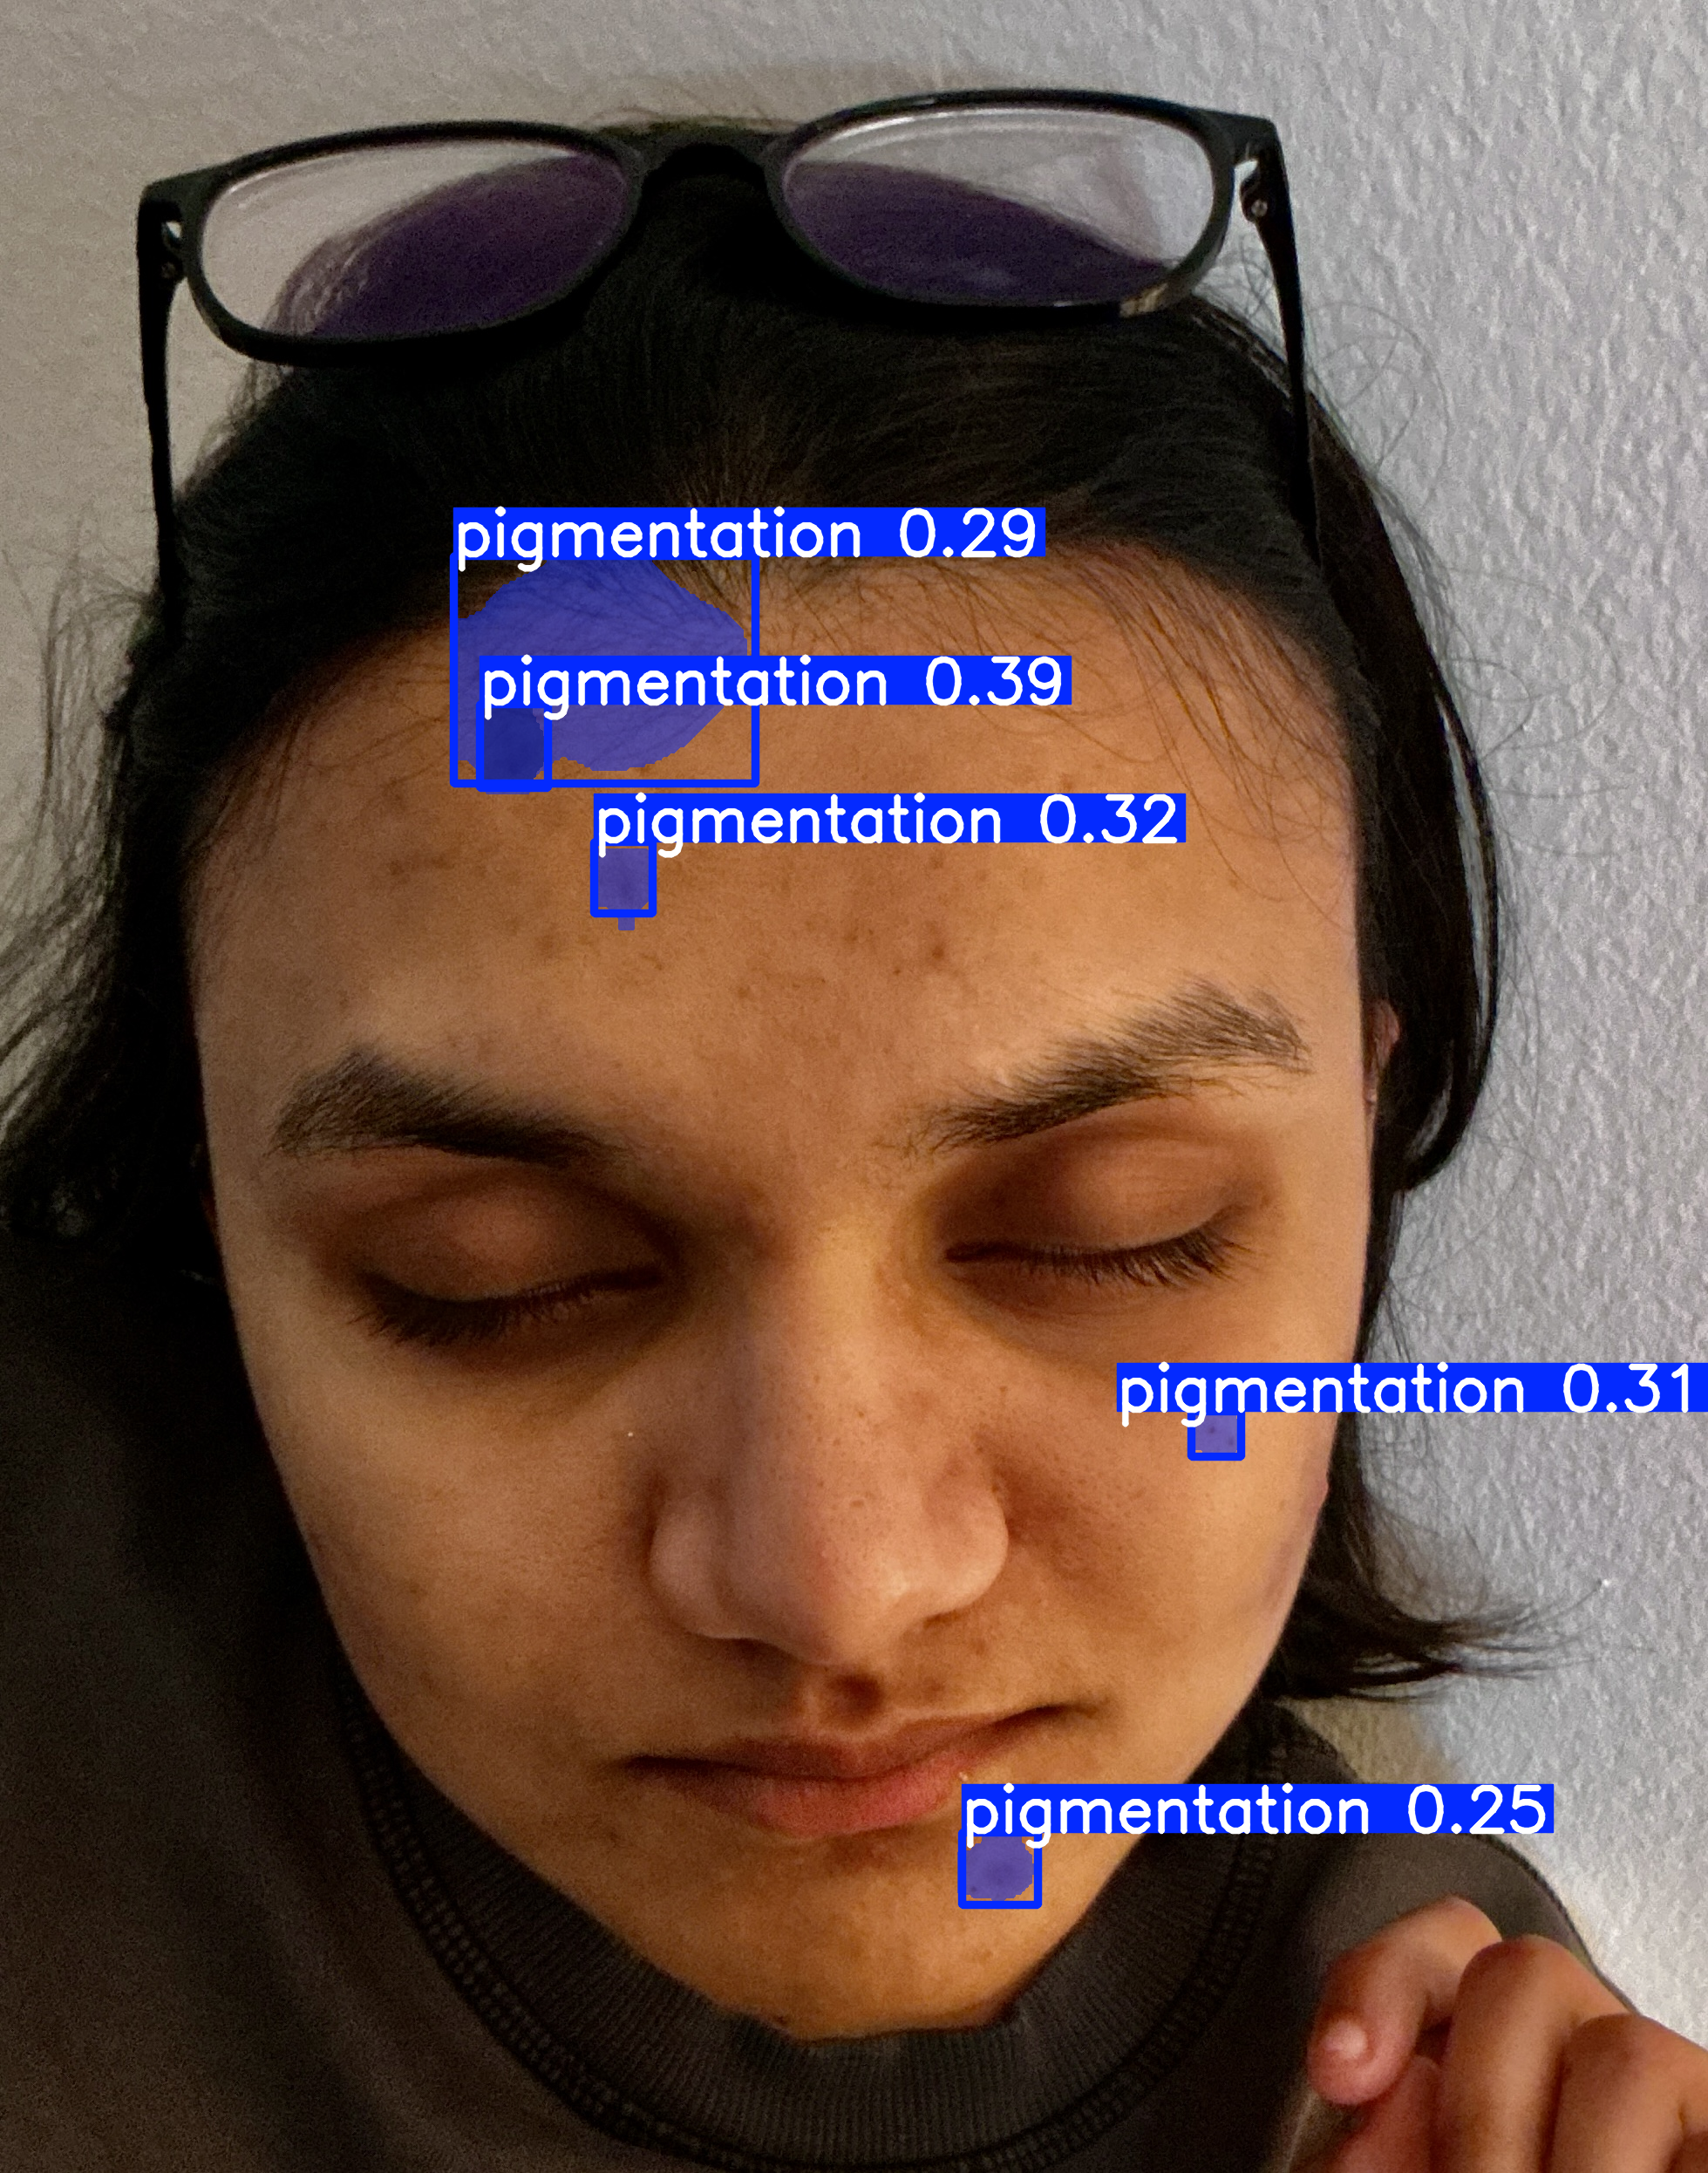

cp: cannot stat 'results/run/weights/best.pt': No such file or directory

✓ Model saved to Google Drive!


In [3]:
# ============================================================================
# STEP 3: Test & Save
# ============================================================================

# Validate
best_model = YOLO('/content/runs/segment/results/run2/weights/best.pt')
metrics = best_model.val()

print(f"\nmAP50: {metrics.seg.map50:.3f}")
print(f"mAP50-95: {metrics.seg.map:.3f}")

# Test on an image
TEST_IMAGE = '/content/drive/MyDrive/Hyperpigmentation /Original photo/IMG_0193.JPG'  # Update this
results = best_model(TEST_IMAGE)
results[0].show()

# Save to Drive
!cp results/run/weights/best.pt /content/drive/MyDrive/hyperpigmentation_model.pt
print("\n✓ Model saved to Google Drive!")